# CS-7641 Assignment 3

## Data Loading

### Load Necessary Packages

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, ValidationCurveDisplay, LearningCurveDisplay
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, silhouette_score, homogeneity_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, PredictionErrorDisplay
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import Isomap
from sklearn.metrics import adjusted_rand_score
from scipy.stats import kurtosis
import seaborn as sns

from collections import Counter
import itertools
import timeit
import time



### Load Bank Marketing Dataset

In [24]:
# If this file reference does not work, please update accordingly.
df_bank = pd.read_csv("./dataset/bank/bank.csv")

# Check if dataset contains missing data
if df_bank.isnull().values.any():
    print("There are missing data in the dataset")

### Load Phishing Websites Dataset

In [25]:
df_phish = pd.read_csv("./dataset/phishing/Phishing_Legitimate_full.csv")

# Check if dataset contains missing data
if df_phish.isnull().values.any():
    print("There are missing data in the dataset")

## Data Preprocessing

### Preprocess Bank Marketing Dataset

In [26]:
col_1hot = ['job','marital','education','default','housing','loan','contact','day', 'month','poutcome']
df_1hot = df_bank[col_1hot]
df_1hot = pd.get_dummies(df_1hot).astype('category')
df_others = df_bank.drop(col_1hot,axis=1)
df_bank = pd.concat([df_others,df_1hot],axis=1)
column_order = list(df_bank)
column_order.insert(0, column_order.pop(column_order.index('deposit')))
df_bank = df_bank.loc[:, column_order]
df_bank['deposit'].replace("no",0,inplace=True)
df_bank['deposit'].replace("yes",1,inplace=True)
df_bank['deposit'] = df_bank['deposit'].astype('category')

numericcols = ['age','duration','campaign','pdays','previous']
df_num = df_bank[numericcols]
df_stand =(df_num-df_num.min())/(df_num.max()-df_num.min())
df_bank_categorical = df_bank.drop(numericcols,axis=1)
df_bank = pd.concat([df_bank_categorical,df_stand],axis=1)
#df_bank.describe(include='all')


## Generate Training and Test Data

We will be splitting up the datasets into training and test data. We will use 20% of each dataset as test data.

### Generate Data for Phishing Dataset

In [27]:
# Generate for Phishing Data
# target column that we want is 'CLASS_LABEL'
df_phish_X = df_phish.drop(["CLASS_LABEL"], axis=1)
df_phish_y = df_phish["CLASS_LABEL"]

phish_X, phish_Y = np.array(df_phish_X), np.array(df_phish_y)

phish_X_train, phish_X_test, phish_y_train, phish_y_test = train_test_split(
    np.array(df_phish_X), np.array(df_phish_y), test_size=0.20
)

### Generate Data for Bank Dataset

In [28]:
# Generate for Resale Data
# target column that we want is 'deposit'
df_bank_x = df_bank.drop(['deposit'], axis=1)
df_bank_y = df_bank['deposit']

bank_X, bank_Y = np.array(df_bank_x), np.array(df_bank_y)

bank_X_train, bank_X_test, bank_y_train, bank_y_test = train_test_split(
    np.array(df_bank_x), np.array(df_bank_y), test_size=0.20
)

print('Shape of bank_X_train:', bank_X_train.shape)
print('Shape of bank_X_test:', bank_X_test.shape)
print('Shape of bank_y_train:', bank_y_train.shape)
print('Shape of bank_y_test:', bank_y_test.shape)

Shape of bank_X_train: (8929, 51)
Shape of bank_X_test: (2233, 51)
Shape of bank_y_train: (8929,)
Shape of bank_y_test: (2233,)


## 1. Clustering

### Expectation Maximisation

#### Phishing Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


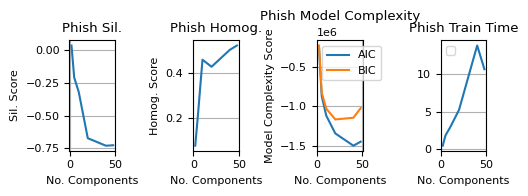

In [36]:
# fit a Gaussian Mixture Model with two components

n_components_range = [2, 5, 10, 20, 40, 48]
distortions = []
train_times = []
f1_scores= []
sil_scores = []
homo_scores = []
aic_scores = []
bic_scores = []

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return pred

for curr_comp in n_components_range:
    start = timeit.default_timer()
    clf = GaussianMixture(n_components=curr_comp, covariance_type="full", warm_start=True, random_state=50)
    clf.fit(phish_X_train)
    train_times.append(timeit.default_timer() - start)

    labels = clf.predict(phish_X_train)
    sil_scores.append(silhouette_score(phish_X_train, labels))
    homo_scores.append(homogeneity_score(phish_y_train, labels))
    aic_scores.append(clf.aic(phish_X_train))
    bic_scores.append(clf.bic(phish_X_train))

# Create the four graphs
plt.rcParams.update({'font.size': 8})
plt.rc('axes.formatter', useoffset=False)
plt.figure(figsize=(5, 2))

# Silhouette score
plt.subplot(141)
plt.plot(n_components_range, sil_scores)
plt.grid(True)
plt.xlabel('No. Components')
plt.ylabel('Sil. Score')
plt.title('Phish Sil.')

# Homogeneity scores
plt.subplot(142)
plt.plot(n_components_range, homo_scores)
plt.grid(True)
plt.xlabel('No. Components')
plt.ylabel('Homog. Score')
plt.title('Phish Homog.')

# AIC and BIC
plt.subplot(143)
plt.plot(n_components_range, aic_scores, label='AIC')
plt.plot(n_components_range, bic_scores,label='BIC')
plt.grid(True)
plt.xlabel('No. Components')
plt.ylabel('Model Complexity Score')
plt.title('Phish Model Complexity')
plt.legend(loc="best")

# Train times
plt.subplot(144)
plt.plot(n_components_range, train_times)
plt.grid(True)
plt.xlabel('No. Components')
plt.title('Phish Train Time')
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [37]:
param_grid = {
    "n_components": [2, 5, 10, 20, 40, 48]
}

tree = GridSearchCV(estimator=GaussianMixture(covariance_type="full", warm_start=True, random_state=50), param_grid=param_grid, cv=10)
tree.fit(phish_X, phish_Y)
print("Best params are:")
print(tree.best_params_)
df_phish_tree_result = pd.DataFrame.from_dict(tree.cv_results_)
print(df_phish_tree_result.loc[tree.best_index_])

phish_em_best_n_components = tree.best_params_['n_components']

Best params are:
{'n_components': 2}
mean_fit_time                    0.497797
std_fit_time                     0.106236
mean_score_time                  0.001609
std_score_time                   0.000507
param_n_components                      2
params                {'n_components': 2}
split0_test_score               13.579225
split1_test_score               20.684958
split2_test_score                6.608406
split3_test_score             -505.659853
split4_test_score               -2.774175
split5_test_score              -51.645381
split6_test_score              -61.134516
split7_test_score              -977.83419
split8_test_score               13.621967
split9_test_score               16.169815
mean_test_score               -152.838374
std_test_score                 313.969939
rank_test_score                         1
Name: 0, dtype: object


#### Bank Data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


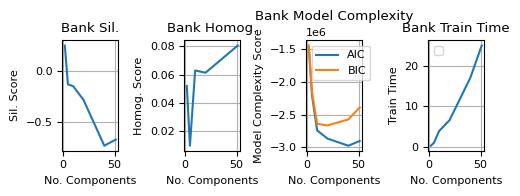

In [39]:
# fit a Gaussian Mixture Model with two components

n_components_range = [2, 5, 10, 20, 40, 51]
distortions = []
train_times = []
f1_scores= []
sil_scores = []
homo_scores = []
aic_scores = []
bic_scores = []

def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return pred

for curr_comp in n_components_range:
    start = timeit.default_timer()
    clf = GaussianMixture(n_components=curr_comp, covariance_type="full", warm_start=True, random_state=50)
    clf.fit(bank_X)
    train_times.append(timeit.default_timer() - start)

    labels = clf.predict(bank_X)
    sil_scores.append(silhouette_score(bank_X, labels))
    homo_scores.append(homogeneity_score(bank_Y, labels))
    aic_scores.append(clf.aic(bank_X))
    bic_scores.append(clf.bic(bank_X))

# Create the four graphs
plt.rcParams.update({'font.size': 8})
plt.rc('axes.formatter', useoffset=False)
plt.figure(figsize=(5, 2))

# Silhouette score
plt.subplot(141)
plt.plot(n_components_range, sil_scores)
plt.grid(True)
plt.xlabel('No. Components')
plt.ylabel('Sil. Score')
plt.title('Bank Sil.')

# Homogeneity scores
plt.subplot(142)
plt.plot(n_components_range, homo_scores)
plt.grid(True)
plt.xlabel('No. Components')
plt.ylabel('Homog. Score')
plt.title('Bank Homog.')

# AIC and BIC
plt.subplot(143)
plt.plot(n_components_range, aic_scores, label='AIC')
plt.plot(n_components_range, bic_scores,label='BIC')
plt.grid(True)
plt.xlabel('No. Components')
plt.ylabel('Model Complexity Score')
plt.title('Bank Model Complexity')
plt.legend(loc="best")

# Train times
plt.subplot(144)
plt.plot(n_components_range, train_times)
plt.grid(True)
plt.xlabel('No. Components')
plt.ylabel('Train Time')
plt.title('Bank Train Time')
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [40]:
param_grid = {
    "n_components": [2, 5, 10, 20, 40, 51]
}

tree = GridSearchCV(estimator=GaussianMixture(covariance_type="full", warm_start=True, random_state=50), param_grid=param_grid, cv=10)
tree.fit(bank_X, bank_Y)
print("Best params are:")
print(tree.best_params_)
df_bank_em_result = pd.DataFrame.from_dict(tree.cv_results_)
print(df_bank_em_result.loc[tree.best_index_])

Best params are:
{'n_components': 2}
mean_fit_time                    0.344538
std_fit_time                     0.069316
mean_score_time                  0.002991
std_score_time                   0.000021
param_n_components                      2
params                {'n_components': 2}
split0_test_score               65.222299
split1_test_score               65.714433
split2_test_score             -451.695932
split3_test_score                55.60244
split4_test_score               59.263528
split5_test_score               69.971814
split6_test_score             -418.684459
split7_test_score               70.302238
split8_test_score               66.967011
split9_test_score               70.529778
mean_test_score                -34.680685
std_test_score                 200.442514
rank_test_score                         1
Name: 0, dtype: object


### K-Means

#### Phishing Data

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

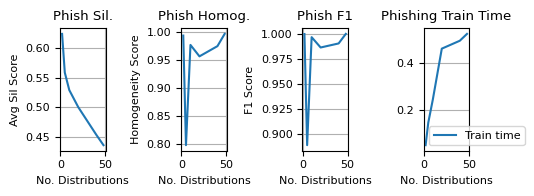

In [44]:
n_components_range = [2, 5, 10, 20, 40, 48]
distortions = []
kmeans_phishing_train_times = []
kmeans_phishing_f1_scores= []
kmeans_phishing_sil_scores = []
kmeans_phishing_homo_scores = []
# aic_scores = []
# bic_scores = []

def cluster_predictions(Y,clusterLabels):
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target 
    return pred

for curr_cluster in n_components_range:
    start = timeit.default_timer()
    clf = KMeans(n_clusters=curr_cluster, random_state=50)
    clf.fit(phish_X_train)
    kmeans_phishing_train_times.append(timeit.default_timer() - start)
    # closest = np.min(cdist(phish_X_train, gm.means_, 'euclidean'), axis=1)
    # distortions.append(sum(closest / phish_X_train.shpae[0]))

    labels = clf.predict(phish_X_train)
    kmeans_phishing_sil_scores.append(silhouette_score(phish_X_train, labels))
    y_mode_vote = cluster_predictions(phish_y_train,labels)
    kmeans_phishing_f1_scores.append(f1_score(phish_y_train, y_mode_vote))
    kmeans_phishing_homo_scores.append(homogeneity_score(phish_y_train, labels))

plt.figure(figsize=(5, 2))
plt.rc('axes.formatter', useoffset=False)


# elbow curve for silhouette score
plt.subplot(141)
plt.plot(n_components_range, kmeans_phishing_sil_scores)
plt.grid(True)
plt.xlabel('No. Distributions')
plt.ylabel('Avg Sil Score')
plt.title('Phish Sil.')

# plot homogeneity scores
plt.subplot(142)
plt.plot(n_components_range, kmeans_phishing_homo_scores)
plt.grid(True)
plt.xlabel('No. Distributions')
plt.ylabel('Homogeneity Score')
plt.title('Phish Homog.')

# plot f1 scores
plt.subplot(143)
plt.plot(n_components_range, kmeans_phishing_f1_scores)
plt.grid(True)
plt.xlabel('No. Distributions')
plt.ylabel('F1 Score')
plt.title('Phish F1')

# plot train times
plt.subplot(144)
plt.plot(n_components_range, kmeans_phishing_train_times, label='Train time')
plt.grid(True)
plt.xlabel('No. Distributions')
plt.title('Phishing Train Time')
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [43]:
param_grid = {
    "n_clusters": [2, 5, 10, 20, 40, 48]
}

tree = GridSearchCV(estimator=KMeans(random_state=50), param_grid=param_grid, cv=10)
tree.fit(phish_X_train, phish_y_train)
print("Best params are:")
print(tree.best_params_)
df_phish_tree_result = pd.DataFrame.from_dict(tree.cv_results_)
print(df_phish_tree_result.loc[tree.best_index_])

phish_kmeans_best_n_clusters = tree.best_params_['n_clusters']

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

Best params are:
{'n_clusters': 48}
mean_fit_time                  0.513108
std_fit_time                   0.071606
mean_score_time                0.002499
std_score_time                 0.000499
param_n_clusters                     48
params               {'n_clusters': 48}
split0_test_score       -4440675.141515
split1_test_score       -4878233.858735
split2_test_score       -4575652.670402
split3_test_score       -4862535.106064
split4_test_score       -4830427.118647
split5_test_score       -4708746.903108
split6_test_score       -4850100.364322
split7_test_score       -5074903.408188
split8_test_score       -4597466.594959
split9_test_score       -4863741.128148
mean_test_score         -4768248.229409
std_test_score            176582.299273
rank_test_score                       1
Name: 5, dtype: object


#### Bank Data

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

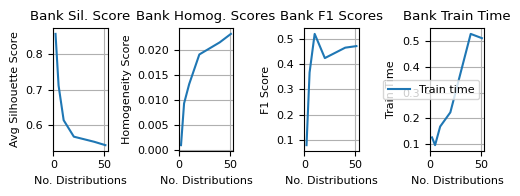

In [45]:
clusters = [2, 5, 10, 20, 40, 51]

distortions = []
kmeans_banking_train_times = []
kmeans_banking_f1_scores = []
kmeans_banking_sil_scores = []
kmeans_banking_homo_scores = []


def cluster_predictions(Y, clusterLabels):
    assert Y.shape == clusterLabels.shape
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return pred


for curr_cluster in clusters:
    start = timeit.default_timer()
    clf = KMeans(n_clusters=curr_cluster, random_state=50)
    clf.fit(bank_X_train)
    kmeans_banking_train_times.append(timeit.default_timer() - start)
    # closest = np.min(cdist(bank_X_train, gm.means_, 'euclidean'), axis=1)
    # distortions.append(sum(closest / bank_X_train.shpae[0]))

    labels = clf.predict(bank_X_train)
    kmeans_banking_sil_scores.append(silhouette_score(bank_X_train, labels))
    y_mode_vote = cluster_predictions(bank_y_train, labels)
    kmeans_banking_f1_scores.append(f1_score(bank_y_train, y_mode_vote))
    kmeans_banking_homo_scores.append(homogeneity_score(bank_y_train, labels))

plt.figure(figsize=(5, 2))
plt.rc('axes.formatter', useoffset=False)

# elbow curve for silhouette score
plt.subplot(141)
plt.plot(clusters, kmeans_banking_sil_scores)
plt.grid(True)
plt.xlabel("No. Distributions")
plt.ylabel("Avg Silhouette Score")
plt.title("Bank Sil. Score")

# plot homogeneity scores
plt.subplot(142)
plt.plot(clusters, kmeans_banking_homo_scores)
plt.grid(True)
plt.xlabel("No. Distributions")
plt.ylabel("Homogeneity Score")
plt.title("Bank Homog. Scores")

# plot f1 scores
plt.subplot(143)
plt.plot(clusters, kmeans_banking_f1_scores)
plt.grid(True)
plt.xlabel("No. Distributions")
plt.ylabel("F1 Score")
plt.title("Bank F1 Scores")

# plot train times
plt.subplot(144)
plt.plot(clusters, kmeans_banking_train_times, label="Train time")
plt.grid(True)
plt.xlabel("No. Distributions")
plt.ylabel("Train Time")
plt.title("Bank Train Time")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [46]:
param_grid = {
    "n_clusters": [2, 5, 10, 20, 40, 51]

}

tree = GridSearchCV(estimator=KMeans(random_state=50), param_grid=param_grid, cv=10)
tree.fit(bank_X_train, bank_y_train)
print("Best params are:")
print(tree.best_params_)
df_bank_tree_result = pd.DataFrame.from_dict(tree.cv_results_)
df_bank_tree_result.loc[tree.best_index_]

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

Best params are:
{'n_clusters': 51}


mean_fit_time                  0.469653
std_fit_time                   0.022549
mean_score_time                0.004112
std_score_time                 0.000536
param_n_clusters                     51
params               {'n_clusters': 51}
split0_test_score      -12389257.932239
split1_test_score      -33071930.077371
split2_test_score       -9720176.627348
split3_test_score       -7539810.306242
split4_test_score       -7751087.504911
split5_test_score      -33854890.074321
split6_test_score     -107374525.293748
split7_test_score       -8567564.285479
split8_test_score       -60989687.63143
split9_test_score       -9183138.640694
mean_test_score        -29044206.837378
std_test_score          30944973.983058
rank_test_score                       1
Name: 5, dtype: object

## 2. Dimensionality Reduction

### PCA

#### Phishing Data

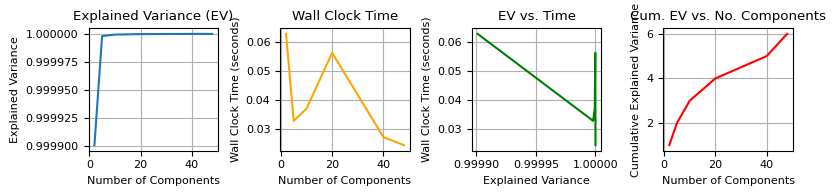

In [47]:
# Define a range of components for analysis
n_components_range = [2, 5, 10, 20, 40, 48]

# Initialize empty lists to store results
explained_variance = []
wall_clock_time = []

# Loop through different numbers of components
for n_components in n_components_range:
    start_time = timeit.default_timer()
    
    # Perform PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(phish_X)
    
    end_time = timeit.default_timer()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Create the four graphs
plt.rcParams.update({'font.size': 8})
plt.rc('axes.formatter', useoffset=False)
plt.figure(figsize=(8, 2))

# Graph 1: Explained Variance vs. Number of Components
plt.subplot(141)
plt.plot(n_components_range, explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance (EV)')
plt.grid(True)

# Graph 2: Wall Clock Time vs. Number of Components
plt.subplot(142)
plt.plot(n_components_range, wall_clock_time, color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Wall Clock Time (seconds)')
plt.title('Wall Clock Time')
plt.grid(True)

# Graph 3: Explained Variance vs. Wall Clock Time
plt.subplot(143)
plt.plot(explained_variance, wall_clock_time, color='green')
plt.xlabel('Explained Variance')
plt.ylabel('Wall Clock Time (seconds)')
plt.title('EV vs. Time')
plt.grid(True)

# Graph 4: Explained Variance Cumulative Plot
plt.subplot(144)
explained_variance_cumulative = np.cumsum(explained_variance)
plt.plot(n_components_range, explained_variance_cumulative, color='red')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cum. EV vs. No. Components')
plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
param_grid = {
    "n_components": [2, 5, 10, 20, 40, 48]

}

tree = GridSearchCV(estimator=PCA(), param_grid=param_grid, cv=10)
tree.fit(phish_X, phish_Y)
print("Best params are:")
print(tree.best_params_)
df_phish_pca_result = pd.DataFrame.from_dict(tree.cv_results_)
df_phish_pca_result.loc[tree.best_index_]

Best params are:
{'n_components': 40}


c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [-150.80856823  -69.27184961  -52.44237399  -44.16380507  -31.57978207
          -inf]
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:987: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


mean_fit_time                     0.023627
std_fit_time                      0.000428
mean_score_time                   0.001198
std_score_time                    0.000401
param_n_components                      40
params                {'n_components': 40}
split0_test_score               -39.476385
split1_test_score               -29.674841
split2_test_score               -31.317335
split3_test_score               -43.140118
split4_test_score               -29.986168
split5_test_score                -33.56856
split6_test_score                -30.65293
split7_test_score               -31.270366
split8_test_score                -23.50587
split9_test_score               -23.205248
mean_test_score                 -31.579782
std_test_score                    5.852059
rank_test_score                          1
Name: 4, dtype: object

#### Bank Data

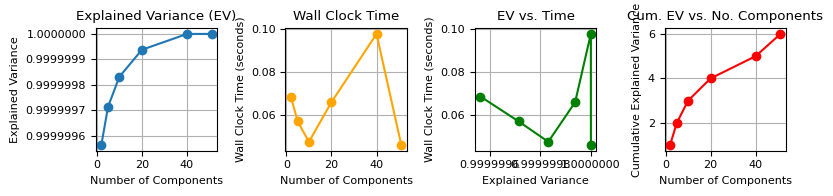

In [49]:
# Define a range of components for analysis
n_components_range = [2, 5, 10, 20, 40, 51]

# Initialize empty lists to store results
explained_variance = []
wall_clock_time = []

# Loop through different numbers of components
for n_components in n_components_range:
    start_time = timeit.default_timer()
    
    # Perform PCA with the current number of components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(bank_X)
    
    end_time = timeit.default_timer()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Create the four graphs
plt.rcParams.update({'font.size': 8})
plt.rc('axes.formatter', useoffset=False)
plt.figure(figsize=(8, 2))

# Graph 1: Explained Variance vs. Number of Components
plt.subplot(141)
plt.plot(n_components_range, explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance (EV)')
plt.grid(True)

# Graph 2: Wall Clock Time vs. Number of Components
plt.subplot(142)
plt.plot(n_components_range, wall_clock_time, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Wall Clock Time (seconds)')
plt.title('Wall Clock Time')
plt.grid(True)

# Graph 3: Explained Variance vs. Wall Clock Time
plt.subplot(143)
plt.plot(explained_variance, wall_clock_time, marker='o', color='green')
plt.xlabel('Explained Variance')
plt.ylabel('Wall Clock Time (seconds)')
plt.title('EV vs. Time')
plt.grid(True)

# Graph 4: Explained Variance Cumulative Plot
plt.subplot(144)
explained_variance_cumulative = np.cumsum(explained_variance)
plt.plot(n_components_range, explained_variance_cumulative, marker='o', color='red')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cum. EV vs. No. Components')
plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
param_grid = {
    "n_components": [2, 5, 10, 20, 40, 51]

}

tree = GridSearchCV(estimator=PCA(), param_grid=param_grid, cv=10)
tree.fit(bank_X, bank_Y)
print("Best params are:")
print(tree.best_params_)
df_phish_pca_result = pd.DataFrame.from_dict(tree.cv_results_)
df_phish_pca_result.loc[tree.best_index_]

Best params are:
{'n_components': 40}


c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [-24.61841268 -19.00109796 -13.99398567  -8.15416434  13.35389017
         -inf]
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:987: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights


mean_fit_time                     0.101498
std_fit_time                      0.003721
mean_score_time                     0.0025
std_score_time                    0.000501
param_n_components                      40
params                {'n_components': 40}
split0_test_score                17.672657
split1_test_score                14.501868
split2_test_score                -3.394703
split3_test_score                  6.32567
split4_test_score                15.765839
split5_test_score                18.707158
split6_test_score                12.991657
split7_test_score                16.652131
split8_test_score                16.959986
split9_test_score                17.356639
mean_test_score                   13.35389
std_test_score                    6.514533
rank_test_score                          1
Name: 4, dtype: object

### ICA

#### Phishing Data

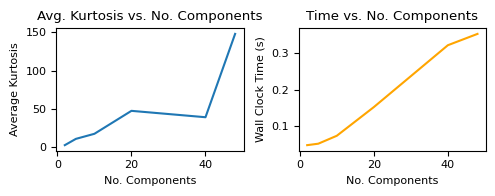

Optimal Number of Components: 48


In [54]:
n_components_range = [2, 5, 10, 20, 40, 48]
kurtosis_values = []
wall_clock_time = []

for n_components in n_components_range:
    start_time = time.time()
    
    # Apply ICA with the current number of components
    ica = FastICA(n_components=n_components, random_state=42)
    components = ica.fit_transform(phish_X)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)
    
    # Calculate kurtosis for each component
    kurtosis_per_component = kurtosis(components, axis=0)
    
    # You may also calculate an average kurtosis value for the components
    avg_kurtosis = np.mean(np.abs(kurtosis_per_component))
    kurtosis_values.append(avg_kurtosis)


# Find the optimal number of components based on maximizing average kurtosis
optimal_components = n_components_range[np.argmax(kurtosis_values)]

plt.figure(figsize=(5, 2))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, kurtosis_values)
plt.xlabel('No. Components')
plt.ylabel('Average Kurtosis')
plt.title('Avg. Kurtosis vs. No. Components')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, wall_clock_time, color='orange')
plt.xlabel('No. Components')
plt.ylabel('Wall Clock Time (s)')
plt.title('Time vs. No. Components')

plt.tight_layout()
plt.show()

print(f'Optimal Number of Components: {optimal_components}')

#### Bank Data

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


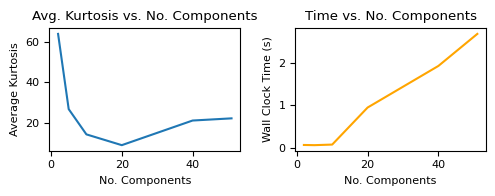

Optimal Number of Components: 2


In [55]:
# Define a range of component numbers to explore
n_components_range = [2, 5, 10, 20, 40, 51]
kurtosis_values = []
wall_clock_time = []

for n_components in n_components_range:
    start_time = time.time()
    
    # Apply ICA with the current number of components
    ica = FastICA(n_components=n_components, random_state=42)
    components = ica.fit_transform(bank_X)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)
    
    # Calculate kurtosis for each component
    kurtosis_per_component = kurtosis(components, axis=0)
    
    # You may also calculate an average kurtosis value for the components
    avg_kurtosis = np.mean(np.abs(kurtosis_per_component))
    kurtosis_values.append(avg_kurtosis)


# Find the optimal number of components based on maximizing average kurtosis
optimal_components = n_components_range[np.argmax(kurtosis_values)]

plt.figure(figsize=(5, 2))

plt.subplot(1, 2, 1)
plt.plot(n_components_range, kurtosis_values)
plt.xlabel('No. Components')
plt.ylabel('Average Kurtosis')
plt.title('Avg. Kurtosis vs. No. Components')

plt.subplot(1, 2, 2)
plt.plot(n_components_range, wall_clock_time, color='orange')
plt.xlabel('No. Components')
plt.ylabel('Wall Clock Time (s)')
plt.title('Time vs. No. Components')

plt.tight_layout()
plt.show()

print(f'Optimal Number of Components: {optimal_components}')



# average_kurtosis = []

# # Calculate kurtosis for different numbers of components
# for n_components in n_components_range:
#     ica = FastICA(n_components=n_components, random_state=50)
#     X_transformed = ica.fit_transform(bank_X)
#     kurtosis_values = kurtosis(X_transformed, axis=0)
#     average_kurtosis.append(np.mean(np.abs(kurtosis_values)))

# # Find the optimal number of components based on maximizing average kurtosis
# optimal_components = n_components_range[np.argmax(average_kurtosis)]

# # Plot the results
# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.plot(n_components_range, average_kurtosis, marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Average Kurtosis')
# plt.title('Average Kurtosis vs. Number of Components')

# plt.subplot(1, 2, 2)
# plt.bar(range(1, len(kurtosis_values) + 1), kurtosis_values)
# plt.xlabel('Component')
# plt.ylabel('Kurtosis')
# plt.title('Kurtosis for Individual Components')

# plt.tight_layout()
# plt.show()

# print(f'Optimal Number of Components: {optimal_components}')

### Randomised Projections

#### Phishing Data

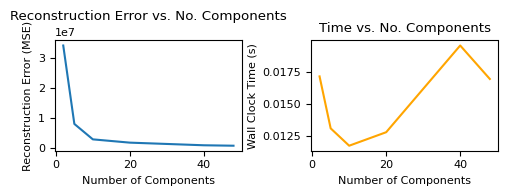

In [67]:
n_components_range = [2, 5, 10, 20, 40, 48]

# Initialize lists to store results
reconstruction_errors = []
wall_clock_time = []

# Loop through different numbers of components
for n_components in n_components_range:
    start_time = timeit.default_timer()
    
    # Perform Randomized Projections with the current number of components
    rp = GaussianRandomProjection(n_components=n_components, random_state=50)
    X_projected = rp.fit_transform(phish_X)
    X_rp = rp.fit_transform(phish_X)
    
    # Inverse transform to get the reconstructed data
    X_reconstructed = np.dot(X_projected, rp.components_)
    
    # Calculate reconstruction error (Mean Squared Error)
    mse = mean_squared_error(phish_X, X_reconstructed)
    reconstruction_errors.append(mse)
    
    end_time = timeit.default_timer()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)

plt.figure(figsize=(5, 2))

# Graph 1: Reconstruction Error vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components_range, reconstruction_errors)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Reconstruction Error vs. No. Components')

# Graph 2: Wall Clock Time vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components_range, wall_clock_time, color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Wall Clock Time (s)')
plt.title('Time vs. No. Components')

plt.tight_layout()
plt.show()

#### Bank Data

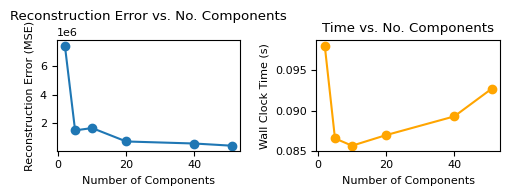

In [70]:
n_components_range = [2, 5, 10, 20, 40, 51]

# Initialize lists to store results
reconstruction_errors = []
wall_clock_time = []

# Loop through different numbers of components
for n_components in n_components_range:
    start_time = timeit.default_timer()
    
    # Perform Randomized Projections with the current number of components
    rp = GaussianRandomProjection(n_components=n_components, random_state=50)
    X_projected = rp.fit_transform(bank_X)
    X_rp = rp.fit_transform(bank_X)
    
    # Inverse transform to get the reconstructed data
    X_reconstructed = np.dot(X_projected, rp.components_)
    
    # Calculate reconstruction error (Mean Squared Error)
    mse = mean_squared_error(bank_X, X_reconstructed)
    reconstruction_errors.append(mse)
    
    end_time = timeit.default_timer()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)

# Create a graph to visualize reconstruction error
plt.figure(figsize=(5, 2))

# Graph 1: Reconstruction Error vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components_range, reconstruction_errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Reconstruction Error vs. No. Components')

# Graph 2: Wall Clock Time vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components_range, wall_clock_time, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Wall Clock Time (s)')
plt.title('Time vs. No. Components')

plt.tight_layout()
plt.show()

### Manifold Leaning (Isomap)

#### Phishing Data

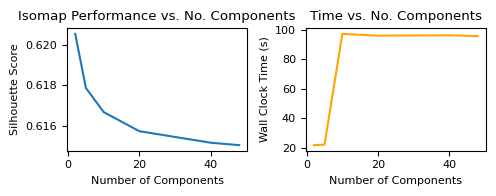

In [72]:
# Define a range of components for analysis
n_components_range = [2, 5, 10, 20, 40, 48]

# Initialize empty lists to store results
silhouette_scores = []
wall_clock_time = []

for n_components in n_components_range:
    start_time = timeit.default_timer()
    
    # Apply Isomap with the current number of components
    isomap = Isomap(n_components=n_components)
    X_transformed = isomap.fit_transform(phish_X)
    
    end_time = timeit.default_timer()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)
    
    # Calculate a performance metric (e.g., silhouette score)
    silhouette_score_value = silhouette_score(X_transformed, phish_Y)  # You can adjust this based on your analysis

    silhouette_scores.append(silhouette_score_value)

# Create two plots
plt.figure(figsize=(5, 2))

# Graph 1: Performance Metric vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components_range, silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Isomap Performance vs. No. Components')

# Graph 2: Wall Clock Time vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components_range, wall_clock_time, color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Wall Clock Time (s)')
plt.title('Time vs. No. Components')

plt.tight_layout()
plt.show()

#### Bank Data

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 13 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_ma

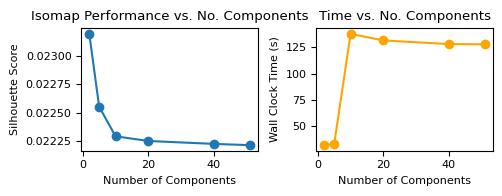

In [73]:
# Define a range of components for analysis
n_components_range = [2, 5, 10, 20, 40, 51]

# Initialize empty lists to store results
silhouette_scores = []
wall_clock_time = []

for n_components in n_components_range:
    start_time = timeit.default_timer()
    
    # Apply Isomap with the current number of components
    isomap = Isomap(n_components=n_components)
    X_transformed = isomap.fit_transform(bank_X)
    
    end_time = timeit.default_timer()
    elapsed_time = end_time - start_time
    wall_clock_time.append(elapsed_time)
    
    # Calculate a performance metric (e.g., silhouette score)
    silhouette_score_value = silhouette_score(X_transformed, bank_Y)  # You can adjust this based on your analysis

    silhouette_scores.append(silhouette_score_value)

# Create two plots
plt.figure(figsize=(5, 2))

# Graph 1: Performance Metric vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Isomap Performance vs. No. Components')

# Graph 2: Wall Clock Time vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components_range, wall_clock_time, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Wall Clock Time (s)')
plt.title('Time vs. No. Components')

plt.tight_layout()
plt.show()

## 3. DR and Clustering

#### Phishing Data

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

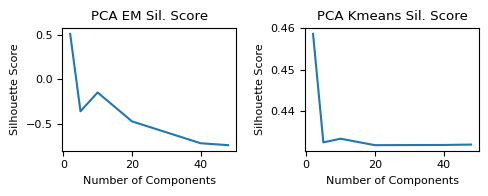

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

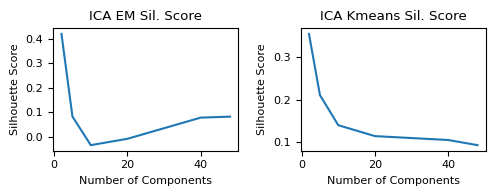

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

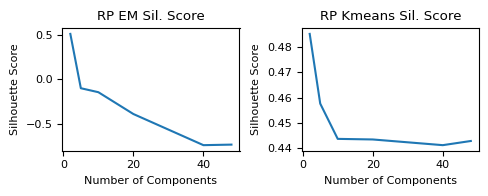

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_mat

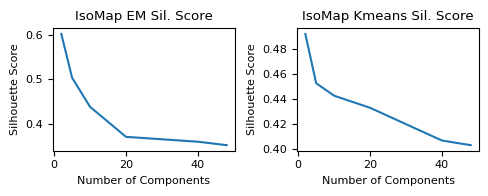

In [80]:
n_components_range = [2, 5, 10, 20, 40, 48]

# # Initialize empty lists to store results
pca_em_silhouette_scores = []
pca_kmeans_silhouette_scores = []
ica_em_silhouette_scores = []
ica_kmeans_silhouette_scores = []
rp_em_silhouette_scores = []
rp_kmeans_silhouette_scores = []
isomap_em_silhouette_scores = []
isomap_kmeans_silhouette_scores = []

for n_components in n_components_range:
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components, random_state=50)
    X_pca = pca.fit_transform(phish_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_pca)
    pca_em_silhouette_scores.append(silhouette_score(X_pca, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=48, random_state=50)
    cluster_labels = kmeans.fit_predict(X_pca)
    pca_kmeans_silhouette_scores.append(silhouette_score(X_pca, cluster_labels))

plt.figure(figsize=(5, 2))


plt.subplot(121)
plt.plot(n_components_range, pca_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('PCA EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, pca_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('PCA Kmeans Sil. Score')

plt.tight_layout()
plt.show()

for n_components in n_components_range:
    # Apply ICA for dimensionality reduction
    ica = FastICA(n_components=n_components, random_state=0)
    X_ica = ica.fit_transform(phish_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_ica)
    ica_em_silhouette_scores.append(silhouette_score(X_ica, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=48, random_state=50)
    cluster_labels = kmeans.fit_predict(X_ica)
    ica_kmeans_silhouette_scores.append(silhouette_score(X_ica, cluster_labels))

plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.plot(n_components_range, ica_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('ICA EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, ica_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('ICA Kmeans Sil. Score')

plt.tight_layout()
plt.show()

for n_components in n_components_range:
    # Apply RP for dimensionality reduction
    rp = GaussianRandomProjection(n_components=n_components, random_state=50)
    X_rp = rp.fit_transform(phish_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_rp)
    rp_em_silhouette_scores.append(silhouette_score(X_rp, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=48, random_state=50)
    cluster_labels = kmeans.fit_predict(X_rp)
    rp_kmeans_silhouette_scores.append(silhouette_score(X_rp, cluster_labels))

plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.plot(n_components_range, rp_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('RP EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, rp_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('RP Kmeans Sil. Score')

plt.tight_layout()
plt.show()

for n_components in n_components_range:
    # Apply IsoMap for dimensionality reduction
    iso = Isomap(n_components=n_components)
    X_iso = iso.fit_transform(phish_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_iso)
    isomap_em_silhouette_scores.append(silhouette_score(X_iso, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=48, random_state=50)
    cluster_labels = kmeans.fit_predict(X_iso)
    isomap_kmeans_silhouette_scores.append(silhouette_score(X_iso, cluster_labels))


plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.plot(n_components_range, isomap_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('IsoMap EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, isomap_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('IsoMap Kmeans Sil. Score')

plt.tight_layout()
plt.show()


#### Bank Data

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

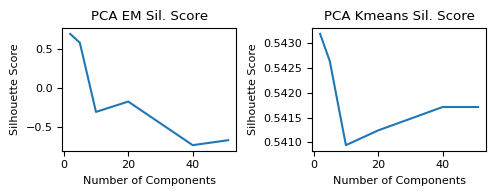

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\decompos

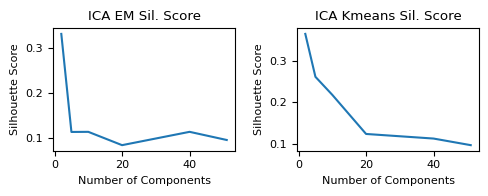

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

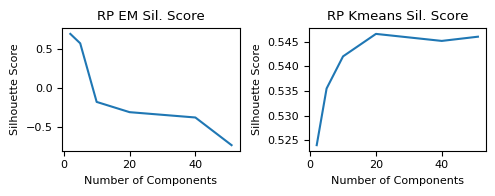

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 13 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_ma

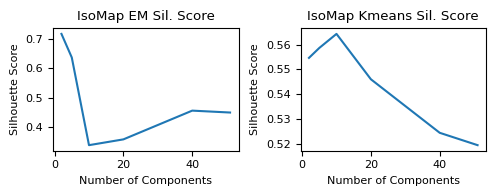

In [81]:
n_components_range = [2, 5, 10, 20, 40, 51]

# # Initialize empty lists to store results
pca_em_silhouette_scores = []
pca_kmeans_silhouette_scores = []
ica_em_silhouette_scores = []
ica_kmeans_silhouette_scores = []
rp_em_silhouette_scores = []
rp_kmeans_silhouette_scores = []
isomap_em_silhouette_scores = []
isomap_kmeans_silhouette_scores = []

for n_components in n_components_range:
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components, random_state=50)
    X_pca = pca.fit_transform(bank_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_pca)
    pca_em_silhouette_scores.append(silhouette_score(X_pca, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=51, random_state=50)
    cluster_labels = kmeans.fit_predict(X_pca)
    pca_kmeans_silhouette_scores.append(silhouette_score(X_pca, cluster_labels))

plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.plot(n_components_range, pca_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('PCA EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, pca_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('PCA Kmeans Sil. Score')

plt.tight_layout()
plt.show()

for n_components in n_components_range:
    # Apply ICA for dimensionality reduction
    ica = FastICA(n_components=n_components, random_state=0)
    X_ica = ica.fit_transform(bank_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_ica)
    ica_em_silhouette_scores.append(silhouette_score(X_ica, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=51, random_state=50)
    cluster_labels = kmeans.fit_predict(X_ica)
    ica_kmeans_silhouette_scores.append(silhouette_score(X_ica, cluster_labels))

plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.plot(n_components_range, ica_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('ICA EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, ica_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('ICA Kmeans Sil. Score')

plt.tight_layout()
plt.show()

for n_components in n_components_range:
    # Apply RP for dimensionality reduction
    rp = GaussianRandomProjection(n_components=n_components, random_state=50)
    X_rp = rp.fit_transform(bank_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_rp)
    rp_em_silhouette_scores.append(silhouette_score(X_rp, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=51, random_state=50)
    cluster_labels = kmeans.fit_predict(X_rp)
    rp_kmeans_silhouette_scores.append(silhouette_score(X_rp, cluster_labels))

plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.plot(n_components_range, rp_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('RP EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, rp_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('RP Kmeans Sil. Score')

plt.tight_layout()
plt.show()

for n_components in n_components_range:
    # Apply IsoMap for dimensionality reduction
    iso = Isomap(n_components=n_components)
    X_iso = iso.fit_transform(bank_X)
    # Apply EM
    em = GaussianMixture(n_components=n_components, covariance_type="full", warm_start=True, random_state=50)
    labels = em.fit_predict(X_iso)
    isomap_em_silhouette_scores.append(silhouette_score(X_iso, labels))
    # Apply K-Means clustering on the reduced data
    kmeans = KMeans(n_clusters=51, random_state=50)
    cluster_labels = kmeans.fit_predict(X_iso)
    isomap_kmeans_silhouette_scores.append(silhouette_score(X_iso, cluster_labels))


plt.figure(figsize=(5, 2))

plt.subplot(121)
plt.plot(n_components_range, isomap_em_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('IsoMap EM Sil. Score')

plt.subplot(122)
plt.plot(n_components_range, isomap_kmeans_silhouette_scores)
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('IsoMap Kmeans Sil. Score')

plt.tight_layout()
plt.show()

## 4. DR and Neural Network

#### Phishing

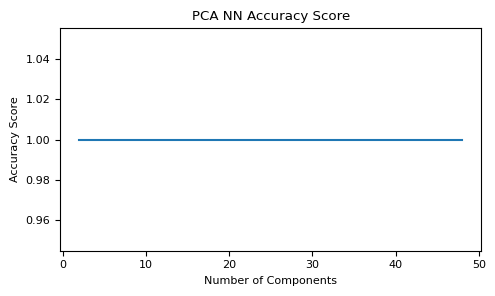

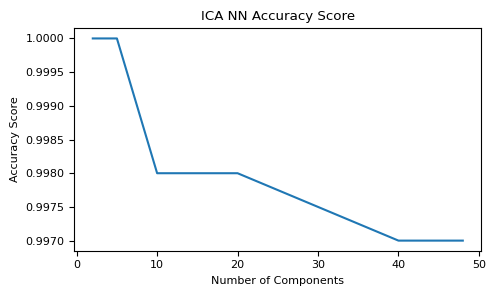

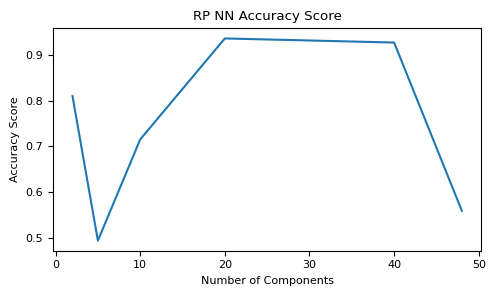

c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_mat

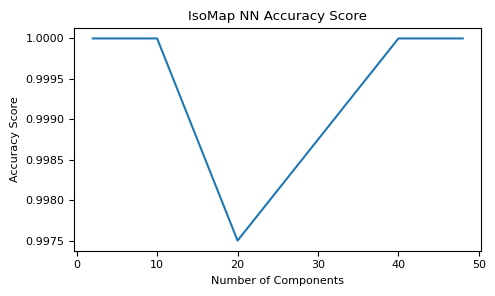

In [79]:
n_components_range = [2, 5, 10, 20, 40, 48]

# # Initialize empty lists to store results
pca_accuracy = []
ica_accuracy = []
rp_accuracy = []
isomap_accuracy = []

for n_components in n_components_range:
    
    pca = PCA(n_components=n_components, random_state=50)
    X_train_reduced = pca.fit_transform(phish_X_train)
    X_test_reduced = pca.transform(phish_X_test)

    # Create and train an MLPClassifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 10), max_iter=1000, random_state=50)

    mlp_classifier.fit(X_train_reduced, phish_y_train)

    # Predict on the test set
    y_pred = mlp_classifier.predict(X_test_reduced)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(phish_y_test, y_pred)
    pca_accuracy.append(accuracy)

plt.figure(figsize=(5, 3))

plt.plot(n_components_range, pca_accuracy)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Score')
plt.title('PCA NN Accuracy Score')

plt.tight_layout()
plt.show()

for n_components in n_components_range:
    
    ica = FastICA(n_components=n_components, random_state=0)
    X_train_reduced = ica.fit_transform(phish_X_train)
    X_test_reduced = ica.transform(phish_X_test)

    # Create and train an MLPClassifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 10), max_iter=1000, random_state=50)

    mlp_classifier.fit(X_train_reduced, phish_y_train)

    # Predict on the test set
    y_pred = mlp_classifier.predict(X_test_reduced)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(phish_y_test, y_pred)
    ica_accuracy.append(accuracy)

plt.figure(figsize=(5, 3))

plt.plot(n_components_range, ica_accuracy)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Score')
plt.title('ICA NN Accuracy Score')

plt.tight_layout()
plt.show()


for n_components in n_components_range:
    
    rp = GaussianRandomProjection(n_components=n_components, random_state=50)
    X_train_reduced = rp.fit_transform(phish_X_train)
    X_test_reduced = rp.transform(phish_X_test)

    # Create and train an MLPClassifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 10), max_iter=1000, random_state=50)

    mlp_classifier.fit(X_train_reduced, phish_y_train)

    # Predict on the test set
    y_pred = mlp_classifier.predict(X_test_reduced)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(phish_y_test, y_pred)
    rp_accuracy.append(accuracy)

plt.figure(figsize=(5, 3))

plt.plot(n_components_range, rp_accuracy)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Score')
plt.title('RP NN Accuracy Score')

plt.tight_layout()
plt.show()


for n_components in n_components_range:
    
    iso = Isomap(n_components=n_components)
    X_train_reduced = iso.fit_transform(phish_X_train)
    X_test_reduced = iso.transform(phish_X_test)

    # Create and train an MLPClassifier
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 10), max_iter=1000, random_state=50)

    mlp_classifier.fit(X_train_reduced, phish_y_train)

    # Predict on the test set
    y_pred = mlp_classifier.predict(X_test_reduced)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(phish_y_test, y_pred)
    isomap_accuracy.append(accuracy)

plt.figure(figsize=(5, 3))

plt.plot(n_components_range, isomap_accuracy)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy Score')
plt.title('IsoMap NN Accuracy Score')

plt.tight_layout()
plt.show()


## 5. Clustering and Neural Network

2


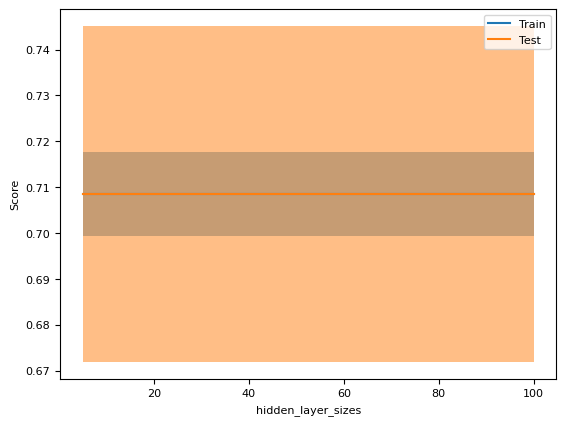

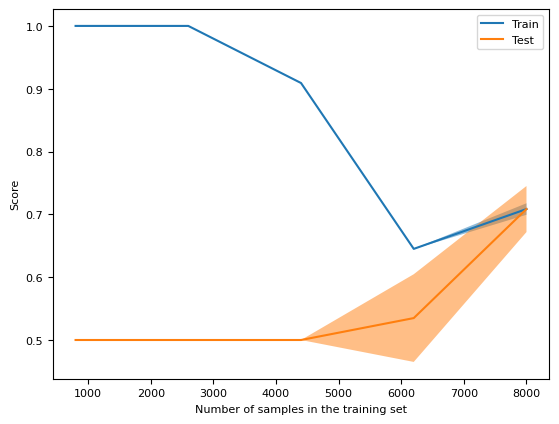

In [78]:
# Get best EM config
print(phish_best_n_components)

# Initialize and fit the Gaussian Mixture model (EM)
gmm = GaussianMixture(n_components=phish_best_n_components, random_state=50)
cluster_labels = gmm.fit_predict(phish_X)

# # Initialize MLPClassifier and use cluster labels as features
# mlp = MLPClassifier(hidden_layer_sizes=(150), learning_rate_init=0.01)
# mlp.fit(cluster_labels.reshape(-1, 1), phish_Y)  # Reshape for MLP input

hidden_layer_list = np.linspace(5, 100, 20).astype('int')
ValidationCurveDisplay.from_estimator(
    MLPClassifier(solver='adam', activation='logistic', max_iter=200),
    cluster_labels.reshape(-1, 1),
    phish_Y,
    param_name="hidden_layer_sizes",
    param_range=hidden_layer_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    MLPClassifier(solver='adam', activation='logistic', max_iter=200),
    cluster_labels.reshape(-1, 1),
    phish_Y
)


48


c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\trevo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximu

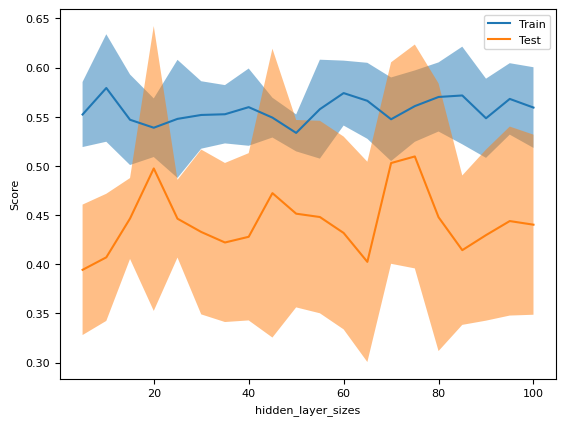

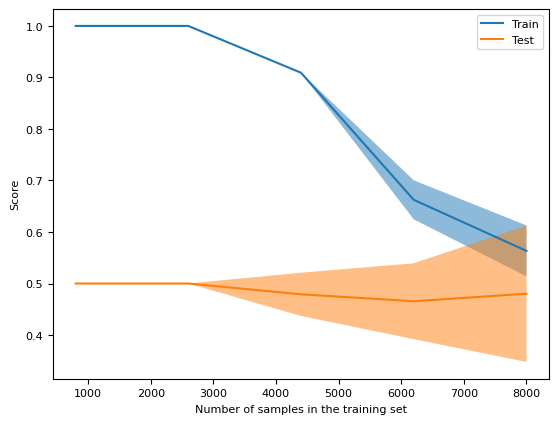

In [22]:
# Get best Kmeans config
print(phish_kmeans_best_n_clusters)

# Initialize and fit the Gaussian Mixture model (EM)
kmeans = KMeans(n_clusters=phish_kmeans_best_n_clusters, random_state=50)
cluster_labels = kmeans.fit_predict(phish_X)

# # Initialize MLPClassifier and use cluster labels as features
# mlp = MLPClassifier(hidden_layer_sizes=(150), learning_rate_init=0.01)
# mlp.fit(cluster_labels.reshape(-1, 1), phish_Y)  # Reshape for MLP input

hidden_layer_list = np.linspace(5, 100, 20).astype('int')
ValidationCurveDisplay.from_estimator(
    MLPClassifier(solver='adam', activation='logistic', max_iter=200),
    cluster_labels.reshape(-1, 1),
    phish_Y,
    param_name="hidden_layer_sizes",
    param_range=hidden_layer_list,
)

# Learning curve
LearningCurveDisplay.from_estimator(
    MLPClassifier(solver='adam', activation='logistic', max_iter=200),
    cluster_labels.reshape(-1, 1),
    phish_Y
)
